<a href="https://colab.research.google.com/github/matthew-lyr/other_stuffs/blob/main/hw8_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework 8 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Sequence-to-Sequence 介紹
- 大多數常見的 **sequence-to-sequence (seq2seq) model** 為 **encoder-decoder model**，主要由兩個部分組成，分別是 **Encoder** 和 **Decoder**，而這兩個部分則大多使用 **recurrent neural network (RNN)** 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將**一連串**的輸入，如文字、影片、聲音訊號等，編碼為**單個向量**，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 Encoder 輸出的單個向量逐步解碼，**一次輸出一個結果**，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - Teachering Forcing 的功用: 嘗試不用 Teachering Forcing 做訓練
  - 實作 Attention Mechanism
  - 實作 Beam Search
  - 實作 Schedule Sampling

# 資料下載

In [1]:
!gdown --id '1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg' --output data.tar.gz
!tar -zxvf data.tar.gz
!mkdir ckpt
!ls

Downloading...
From: https://drive.google.com/uc?id=1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg
To: /content/data.tar.gz
5.83MB [00:00, 51.5MB/s]
cmn-eng/
cmn-eng/int2word_cn.json
cmn-eng/int2word_en.json
cmn-eng/preprocess/
cmn-eng/preprocess/build_dataset.py
cmn-eng/preprocess/build_dictionary.sh
cmn-eng/preprocess/cmn.txt
cmn-eng/preprocess/cn.txt
cmn-eng/preprocess/dict.txt.big
cmn-eng/preprocess/dict.txt.small
cmn-eng/preprocess/en.txt
cmn-eng/preprocess/en_code.txt
cmn-eng/preprocess/en_refine.txt
cmn-eng/preprocess/en_vocab.txt
cmn-eng/preprocess/tokenizer.py
cmn-eng/testing.txt
cmn-eng/training.txt
cmn-eng/validation.txt
cmn-eng/word2int_cn.json
cmn-eng/word2int_en.json
ckpt  cmn-eng  data.tar.gz  sample_data


# 下載和引入需要的 libraries

In [2]:
%%capture
!pip3 install --user nltk

In [ ]:
!pip3 install -U numpy

     |████████████████████████████████| 15.3MB 207kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [7]:
%%capture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

import numpy as np
import sys
import os
import random
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判斷是用 CPU 還是 GPU 執行運算


# 資料結構

## 定義資料的轉換
- 將不同長度的答案拓展到相同長度，以便訓練模型

In [3]:
# def __call__ 是干嘛的？是把object当作function使，比如 e = LabelTransform() 建立object之后 可以直接run e()
# 比如：
# e = LabelTransform(5,0)
# e(np.array([1,2]))

import numpy as np

class LabelTransform(object):
  def __init__(self, size, pad):
    self.size = size
    self.pad = pad

  def __call__(self, label):
    label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
    return label


In [4]:
e = LabelTransform(5,0)
e(np.array([1,2]))

array([1, 2, 0, 0, 0])

## 定義 Dataset
- Data (出自manythings 的 cmn-eng):
  - 訓練資料：18000句
  - 檢驗資料：  500句
  - 測試資料： 2636句

- 資料預處理:
  - 英文：
    - 用 subword-nmt 套件將word轉為subword
    - 建立字典：取出標籤中出現頻率高於定值的subword
  - 中文：
    - 用 jieba 將中文句子斷詞
    - 建立字典：取出標籤中出現頻率高於定值的詞
  - 特殊字元： < PAD >, < BOS >, < EOS >, < UNK > 
    - < PAD >  ：無意義，將句子拓展到相同長度
    - < BOS >  ：Begin of sentence, 開始字元
    - < EOS >  ：End of sentence, 結尾字元
    - < UNK > ：單字沒有出現在字典裡的字
  - 將字典裡每個 subword (詞) 用一個整數表示，分為英文和中文的字典，方便之後轉為 one-hot vector   

- 處理後的檔案:
  - 字典：
    - int2word_*.json: 將整數轉為文字
    ![int2word_en.json](https://i.imgur.com/31E4MdZ.png)
    - word2int_*.json: 將文字轉為整數
    ![word2int_en.json](https://i.imgur.com/9vI4AS1.png)
    - $*$ 分為英文（en）和中文（cn）
  
  - 訓練資料:
    - 不同語言的句子用 TAB ('\t') 分開
    - 字跟字之間用空白分開
    ![data](https://i.imgur.com/nSH1fH4.png)


- 在將答案傳出去前，在答案開頭加入 "< BOS >" 符號，並於答案結尾加入 "< EOS >" 符號

In [5]:
import re
import json

batch_size = 60
emb_dim = 256
hid_dim = 512
n_layers = 3
dropout = 0.5
learning_rate = 0.00005
max_output_len = 50              # 最後輸出句子的最大長度
num_steps = 12000                # 總訓練次數
store_steps = 300                # 訓練多少次後須儲存模型
summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
load_model = False               # 是否需載入模型
store_model_path = "./ckpt"      # 儲存模型的位置
load_model_path = None           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
root = "./cmn-eng"          # 資料存放的位置
attention = False                # 是否使用 Attention Mechanism
set_name = 'training'





def get_dictionary(language):
    # 載入字典
    with open(os.path.join(root, f'word2int_{language}.json'), "r") as f:
        word2int = json.load(f)
    with open(os.path.join(root, f'int2word_{language}.json'), "r") as f:
        int2word = json.load(f)
    return word2int, int2word

word2int_cn, int2word_cn = get_dictionary('cn')
word2int_en, int2word_en = get_dictionary('en')






data = []
with open(os.path.join(root, f'{set_name}.txt'), "r") as f:
    for line in f:
        data.append(line)
print (f'{set_name} dataset size: {len(data)}')
print ('# 现在数据长这样，就是个array，每个element是一行')
print (data[0:10])



print ('# 载入的dictionary长这样：')
a = []
for key, item in word2int_cn.items():
    a.append((key,item))
print(a[:10])
a = []
for key, item in int2word_cn.items():
    a.append((key,item))
print(a[:10])
a = []
for key, item in word2int_en.items():
    a.append((key,item))
print(a[:10])
a = []
for key, item in int2word_en.items():
    a.append((key,item))
print(a[:10])


cn_vocab_size = len(word2int_cn)
print(cn_vocab_size)
en_vocab_size = len(word2int_en)
print(en_vocab_size)
transform = LabelTransform(max_output_len, word2int_en['<PAD>'])
print(word2int_en['<PAD>'])

transform = LabelTransform(max_output_len, word2int_en['<PAD>'])

# 每一行怎么拆

sentences = data[0]
sentences = re.split('[\t\n]', sentences)
sentences = list(filter(None, sentences))
#print (sentences)
assert len(sentences) == 2
print(sentences)


# # 預備特殊字元
BOS = word2int_en['<BOS>']
print(BOS)
EOS = word2int_en['<EOS>']
print(EOS)
UNK = word2int_en['<UNK>']
print(UNK)

# # 在開頭添加 <BOS>，在結尾添加 <EOS> ，不在字典的 subword (詞) 用 <UNK> 取代
en, cn = [BOS], [BOS]
# # 將句子拆解為 subword 並轉為整數
sentence = re.split(' ', sentences[0])
print(sentence)
sentence = list(filter(None, sentence))
print(sentence)
# #print (f'en: {sentence}')
for word in sentence:
  en.append(word2int_en.get(word, UNK))
en.append(EOS)
print(en)

# # 將句子拆解為單詞並轉為整數
# # e.g. < BOS >, we, are, friends, < EOS > --> 1, 28, 29, 205, 2
sentence = re.split(' ', sentences[1])
print(sentence)
sentence = list(filter(None, sentence))
print(sentence)
#print (f'cn: {sentence}')
for word in sentence:
  cn.append(word2int_cn.get(word, UNK))
cn.append(EOS)
print(cn)
en, cn = np.asarray(en), np.asarray(cn)
print(en)
print(cn)
# # 用 <PAD> 將句子補到相同長度
en, cn = transform(en), transform(cn)
print(en)
print(cn)
en, cn = torch.LongTensor(en), torch.LongTensor(cn)
print(en)
print(cn)







training dataset size: 18000
# 现在数据长这样，就是个array，每个element是一行
["it 's none of your concern . \t這不關 你 的 事 。 \n", 'she has a habit of bi@@ ting her na@@ ils . \t她 有 咬 指甲 的 習慣 。 \n', 'he is a teacher . \t他 是 老師 。 \n', 'japan re@@ lies on ar@@ a@@ b countries for oil . \t日本 靠 阿拉伯 國家 提供 石油 。 \n', "i 'll dream about you . \t我會 夢到 你 的 。 \n", "i borrowed tom 's phone this morning . \t我 今天 早上 跟 Tom 藉手機 。 \n", "she does n't know how to play golf . \t她 不 知道 怎麼 打 高爾夫球 。 \n", 'tears ro@@ lled down my chee@@ ks . \t淚水 沿着 我 的 面頰 流 了 下來 。 \n', "that 's soft . \t這 很 軟 。 \n", "do n't open this door , please . \t請 不要 打開 此門 。 \n"]
# 载入的dictionary长这样：
[('<PAD>', 0), ('<BOS>', 1), ('<EOS>', 2), ('<UNK>', 3), ('。', 4), ('我', 5), ('的', 6), ('了', 7), ('你', 8), ('他', 9)]
[('0', '<PAD>'), ('1', '<BOS>'), ('2', '<EOS>'), ('3', '<UNK>'), ('4', '。'), ('5', '我'), ('6', '的'), ('7', '了'), ('8', '你'), ('9', '他')]
[('<PAD>', 0), ('<BOS>', 1), ('<EOS>', 2), ('<UNK>', 3), ('.', 4), ('i', 5), ('the', 6), ('to', 7), ('you', 

In [8]:
# 英文：
# 用 subword-nmt 套件將word轉為subword
# 建立字典：取出標籤中出現頻率高於定值的subword
# 中文：
# 用 jieba 將中文句子斷詞
# 建立字典：取出標籤中出現頻率高於定值的詞
# 將字典裡每個 subword (詞) 用一個整數表示，分為英文和中文的字典，方便之後轉為 one-hot vector
# 什么是subword
# 中文句子断词后是什么样子？
# 这两步都没在notebook里包含，是之前做的

# 这一块儿主要就是建一个dataset class能一会儿用来load data
# 然后把文本里的raw data转换成pytorch tensors
# 每组是两个句子，一个是input句子，一个是output句子
# 每个句子里的每一个字都换成数字，然后句子前后都加上标注开始和结尾的数字，然后再把每个句子pad到一样长


# 为什么要转变成one-hot vector，不用word embedding？


import re
import json

class EN2CNDataset(data.Dataset):
  def __init__(self, root, max_output_len, set_name):
    self.root = root

    self.word2int_cn, self.int2word_cn = self.get_dictionary('cn')
    self.word2int_en, self.int2word_en = self.get_dictionary('en')

    # 載入資料
    self.data = []
    with open(os.path.join(self.root, f'{set_name}.txt'), "r") as f:
      for line in f:
        self.data.append(line)
    print (f'{set_name} dataset size: {len(self.data)}')

    self.cn_vocab_size = len(self.word2int_cn)
    self.en_vocab_size = len(self.word2int_en)
    self.transform = LabelTransform(max_output_len, self.word2int_en['<PAD>'])

  def get_dictionary(self, language):
    # 載入字典
    with open(os.path.join(self.root, f'word2int_{language}.json'), "r") as f:
      word2int = json.load(f)
    with open(os.path.join(self.root, f'int2word_{language}.json'), "r") as f:
      int2word = json.load(f)
    return word2int, int2word

  def __len__(self):
    return len(self.data)

  def __getitem__(self, Index):
    # 先將中英文分開
    sentences = self.data[Index]
    sentences = re.split('[\t\n]', sentences)
    sentences = list(filter(None, sentences))
    #print (sentences)
    assert len(sentences) == 2

    # 預備特殊字元
    BOS = self.word2int_en['<BOS>']
    EOS = self.word2int_en['<EOS>']
    UNK = self.word2int_en['<UNK>']

    # 在開頭添加 <BOS>，在結尾添加 <EOS> ，不在字典的 subword (詞) 用 <UNK> 取代
    en, cn = [BOS], [BOS]
    # 將句子拆解為 subword 並轉為整數
    sentence = re.split(' ', sentences[0])
    sentence = list(filter(None, sentence))
    #print (f'en: {sentence}')
    for word in sentence:
      en.append(self.word2int_en.get(word, UNK))
    en.append(EOS)

    # 將句子拆解為單詞並轉為整數
    # e.g. < BOS >, we, are, friends, < EOS > --> 1, 28, 29, 205, 2
    sentence = re.split(' ', sentences[1])
    sentence = list(filter(None, sentence))
    #print (f'cn: {sentence}')
    for word in sentence:
      cn.append(self.word2int_cn.get(word, UNK))
    cn.append(EOS)

    en, cn = np.asarray(en), np.asarray(cn)

    # 用 <PAD> 將句子補到相同長度
    en, cn = self.transform(en), self.transform(cn)
    en, cn = torch.LongTensor(en), torch.LongTensor(cn)

    return en, cn


# 模型架構

## Encoder
- seq2seq模型的編碼器為RNN。 對於每個輸入，，**Encoder** 會輸出**一個向量**和**一個隱藏狀態(hidden state)**，並將隱藏狀態用於下一個輸入，換句話說，**Encoder** 會逐步讀取輸入序列，並輸出單個矢量（最終隱藏狀態）
- 參數:
  - en_vocab_size 是英文字典的大小，也就是英文的 subword 的個數
  - emb_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - hid_dim 是 RNN 輸出和隱藏狀態的維度
  - n_layers 是 RNN 要疊多少層
  - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
- Encoder 的輸入和輸出:
  - 輸入: 
    - 英文的整數序列 e.g. 1, 28, 29, 205, 2
  - 輸出: 
    - outputs: 最上層 RNN 全部的輸出，可以用 Attention 再進行處理
    - hidden: 每層最後的隱藏狀態，將傳遞到 Decoder 進行解碼


In [9]:
# embedding layer里面的weight是哪儿来的？是有default吗，但是如果有default的话，它的row index也应该跟input里面的数字对应吧。input里面每一个数字都是自己做的字典中字的index
# 如果没有强制用word2vector或者Glove的话，embedding layer会被随机生成，然后跟model之后一起被train。上个作业中就是强制用了word2vec，然后设定了embedding layer不会一起被train
# GRU是什么model，知道它应该类似LSTM. 是gated recurrent neural network
# 如果GRU里面设置了bidirectional = True的话那RNN出来的output会是原来的两倍。shape变了。以前是[a,b,c] 现在是[a,b,2c]
# 这里nn.GRU里emb_dim和hid_dim有什么影响？没什么影响，emb_dim指的是每个字用几个数字来表示，hid_dim是经过RNN后每个字用几个数字来表示

class Encoder(nn.Module):
  def __init__(self, en_vocab_size, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(en_vocab_size, emb_dim)
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(dropout)

# input 的shape只有[batch size, sequence len]吧 跟后面decoder的一样
  def forward(self, input):
    # input = [batch size, sequence len, vocab size]
    embedding = self.embedding(input)
    outputs, hidden = self.rnn(self.dropout(embedding))
    # outputs = [batch size, sequence len, hid dim * directions]
    # hidden =  [num_layers * directions, batch size  , hid dim]
    # outputs 是最上層RNN的輸出
        
    return outputs, hidden


In [10]:
a = Encoder(2447,10,3,3,0.1)

# 这个run不了
# a(en) 

# 这个可以run
print(en.shape)
a.embedding(en)
outputs, hidden = a(torch.reshape(en,(1,50)))
outputs.shape

# 因为embedding layer不在乎input的shape，只要input里没有超出embedding layer中设定好的词典数目的数字就好，
# 不能run主要是因为encoder里面的RNN部分，有对于shape的要求，必须至少是三维的 



torch.Size([50])


torch.Size([1, 50, 6])

## Decoder
- **Decoder** 是另一個 RNN，在最簡單的 seq2seq decoder 中，僅使用 **Encoder** 每一層最後的隱藏狀態來進行解碼，而這最後的隱藏狀態有時被稱為 “content vector”，因為可以想像它對整個前文序列進行編碼， 此 “content vector” 用作 **Decoder** 的**初始**隱藏狀態， 而 **Encoder** 的輸出通常用於 Attention Mechanism
- 參數
  - en_vocab_size 是英文字典的大小，也就是英文的 subword 的個數
  - emb_dim 是 embedding 的維度，是用來將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - hid_dim 是 RNN 輸出和隱藏狀態的維度
  - output_dim 是最終輸出的維度，一般來說是將 hid_dim 轉到 one-hot vector 的單詞向量
  - n_layers 是 RNN 要疊多少層
  - dropout 是決定有多少的機率會將某個節點變為0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不用
  - isatt 是來決定是否使用 Attention Mechanism

- Decoder 的輸入和輸出:
  - 輸入:
    - 前一次解碼出來的單詞的整數表示
  - 輸出:
    - hidden: 根據輸入和前一次的隱藏狀態，現在的隱藏狀態更新的結果
    - output: 每個字有多少機率是這次解碼的結果

In [11]:
print(en)
a = Encoder(2447,10,3,7,0.1)
# （en_vocab_size, emb_dim, hid_dim, n_layers, dropout)
outputs, hidden = a(torch.reshape(en,(50,1)))
print(outputs.shape)
print(hidden.shape)
print(torch.mm(outputs.view(50,-1),hidden.view(50,-1)))
# print(outputs)
# print(hidden)

tensor([   1,   17,   18,  722,   19,   32, 2446,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
torch.Size([50, 1, 6])
torch.Size([14, 50, 3])


RuntimeError: ignored

In [101]:

# 这儿为什么有embedding layer？
# decoder吃什么，不是吃encoder吐出来的？不光是
# attention mechanism在这儿干什么，什么意思
# https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
# encoder最后的output貌似是对每一句的

class Decoder(nn.Module):
  def __init__(self, cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
    super().__init__()
    self.cn_vocab_size = cn_vocab_size
    self.hid_dim = hid_dim * 2
    self.n_layers = n_layers
    self.embedding = nn.Embedding(cn_vocab_size, config.emb_dim)
    self.isatt = isatt
    self.attention = Attention(hid_dim)
    # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
    # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
    # self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
    self.input_dim = emb_dim
    self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
    self.embedding2vocab1 = nn.Linear(self.hid_dim, self.hid_dim * 2)
    self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
    self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.cn_vocab_size)
    self.dropout = nn.Dropout(dropout)

# 什么是unsqueeze
# 就是在指定维度在多加一维度
# 比如shape是[5]的 unsqueeze(0) 就成了[1,5], unsqueeze(1) 就成了[5,1]
# 所以这里的hidden就是encoder吐出来的hidden？
# encoder_outputs和attn在这里有什么用？
# 通过decoder里的RNN后有个从embedding恢复出来的步骤。大概意思就是以前每个字是几个数字表示，现在变成一个数字

  def forward(self, input, hidden, encoder_outputs):
    # input = [batch size, vocab size]
    # hidden = [batch size, n layers * directions, hid dim]
    # Decoder 只會是單向，所以 directions=1
    input = input.unsqueeze(1)
    embedded = self.dropout(self.embedding(input))
    # embedded = [batch size, 1, emb dim]

    # 在这儿要干嘛？这里的attention指的是什么？是attention weights？是atention applied
    # 所以这里的self.attention是指怎么用encoder的output和decoder的output做
    if self.isatt:
      attn = self.attention(encoder_outputs, hidden)
      # TODO: 在這裡決定如何使用 Attention，e.g. 相加 或是 接在後面， 請注意維度變化
      embedded = embedded + attn
    output, hidden = self.rnn(embedded, hidden)
    # output = [batch size, 1, hid dim]
    # hidden = [num_layers, batch size, hid dim]

    # 將 RNN 的輸出轉為每個詞出現的機率
    output = self.embedding2vocab1(output.squeeze(1))
    output = self.embedding2vocab2(output)
    prediction = self.embedding2vocab3(output)
    # prediction = [batch size, vocab size]
    return prediction, hidden



## Attention
- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 **Decoder** 更多的資訊
- 主要是根據現在 **Decoder hidden state** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關系的數值來決定該傳給 **Decoder** 那些額外資訊 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **Decoder hidden state** 和 **Encoder outputs** 之間的關係，再對所有算出來的數值做 **softmax** ，最後根據過完 **softmax** 的值對 **Encoder outputs** 做 **weight sum**

- TODO:
實作 Attention Mechanism

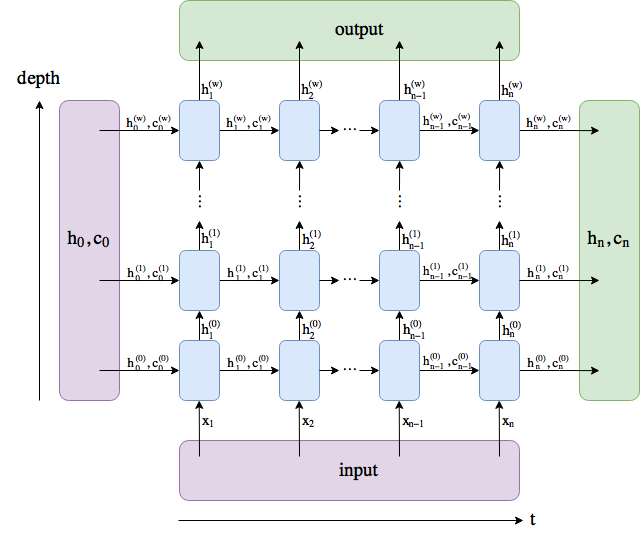

In [56]:
# 我真是服了，到底是什么乘什么？有的说是encoder output 乘以 decoder output，有的说是encoder output乘以decoder hidden state
# 命名真的这么casual吗
# 如何把hidden和output乘起来？
# 为什么hidden和output的shape会是这样？
# https://stackoverflow.com/questions/62618222/luong-style-attention-mechanism-with-dot-and-general-scoring-functions-in-keras

print(en)

# （en_vocab_size, emb_dim, hid_dim, n_layers, dropout)
a = Encoder(2447,10,3,7,0.1)

outputs, hidden = a(torch.reshape(en,(1,50)))
print(outputs.shape)
print(hidden.shape)
print(hidden.view(1,6,-1).shape)
# print(hidden.view(1,-1,1).shape)
# print(outputs.view(1,-1,1).shape)
print(outputs.bmm(hidden.view(1,6,-1)).shape)
print(F.softmax(outputs.bmm(hidden.view(1,6,-1)),dim=1))
print(F.softmax(outputs.bmm(hidden.view(1,6,-1)),dim=1)*)
# print(cn)
# print(outputs.bmm(hidden.view(1,6,-1)).squeeze(2).shape)
# outputs2 = outputs.

# attention_weights

# print(outputs.reshape())
# print(hidden)

# https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
# 所以attention就是个数字，scalar，看之后是加还是乘还是怎么样
# attention 是attention input和attention weights的weighted sum


tensor([   1,   17,   18,  722,   19,   32, 2446,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
torch.Size([1, 50, 6])
torch.Size([14, 1, 3])
torch.Size([1, 6, 7])
torch.Size([1, 50, 7])
tensor([[[0.0235, 0.0172, 0.0160, 0.0255, 0.0214, 0.0223, 0.0197],
         [0.0230, 0.0177, 0.0174, 0.0216, 0.0192, 0.0248, 0.0207],
         [0.0212, 0.0192, 0.0193, 0.0192, 0.0179, 0.0233, 0.0206],
         [0.0206, 0.0195, 0.0195, 0.0195, 0.0186, 0.0230, 0.0213],
         [0.0202, 0.0198, 0.0200, 0.0190, 0.0188, 0.0227, 0.0214],
         [0.0203, 0.0201, 0.0202, 0.0188, 0.0193, 0.0219, 0.0210],
         [0.0206, 0.0206, 0.0207, 0.0182, 0.0198, 0.0209, 0.0203],
         [0.0211, 0.0201, 0.0200, 0.0191, 0.0212, 0.0168, 0.0167],
         [0.0191, 0.0188, 0.0179

tensor([   1,   17,   18,  722,   19,   32, 2446,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
torch.Size([1, 50, 6])
torch.Size([14, 1, 3])
torch.Size([1, 6, 7])
torch.Size([1, 50, 7])
tensor([[[0.0235, 0.0172, 0.0160, 0.0255, 0.0214, 0.0223, 0.0197],
         [0.0230, 0.0177, 0.0174, 0.0216, 0.0192, 0.0248, 0.0207],
         [0.0212, 0.0192, 0.0193, 0.0192, 0.0179, 0.0233, 0.0206],
         [0.0206, 0.0195, 0.0195, 0.0195, 0.0186, 0.0230, 0.0213],
         [0.0202, 0.0198, 0.0200, 0.0190, 0.0188, 0.0227, 0.0214],
         [0.0203, 0.0201, 0.0202, 0.0188, 0.0193, 0.0219, 0.0210],
         [0.0206, 0.0206, 0.0207, 0.0182, 0.0198, 0.0209, 0.0203],
         [0.0211, 0.0201, 0.0200, 0.0191, 0.0212, 0.0168, 0.0167],
         [0.0191, 0.0188, 0.0179

In [100]:
# 我真是服了，到底是什么乘什么？有的说是encoder output 乘以 decoder output，有的说是encoder output乘以decoder hidden state
# 命名真的这么casual吗
# 如何把hidden和output乘起来？
# 为什么hidden和output的shape会是这样？
# https://stackoverflow.com/questions/62618222/luong-style-attention-mechanism-with-dot-and-general-scoring-functions-in-keras

print(en)

# （en_vocab_size, emb_dim, hid_dim, n_layers, dropout)
a = Encoder(2447,10,3,7,0.1)

outputs, hidden = a(torch.reshape(en,(1,50)))

batch_size, sequence_len, hid_dim_times_directions = outputs.shape
num_layers, _, _ = hidden.shape

print(outputs.shape)
print(hidden.shape)
dot_product = outputs.bmm(hidden.view(batch_size,hid_dim_times_directions,-1))
weights = F.softmax(nn.Linear(dot_product.shape[2],1)(dot_product),dim=1).squeeze(2)
squeezed_output = nn.Linear(hid_dim_times_directions,1)(outputs).squeeze(2)
weighted_sum = torch.sum(squeezed_output*weights,dim=1)
print(weighted_sum)
print(outputs)
print(weighted_sum+outputs)

# print(weights.shape)
# print(dot_product.shape)
# print(squeezed_output.shape)
# print((squeezed_output*weights))
# print(nn.Linear(hid_dim_times_directions,1)(outputs).shape)



# print(hidden.view(1,6,-1).shape)
# print(hidden.view(1,-1,1).shape)
# print(outputs.view(1,-1,1).shape)
# print(outputs.bmm(hidden.view(1,6,-1)).shape)
# print(F.softmax(outputs.bmm(hidden.view(1,6,-1)),dim=1))
# print(nn.Linear(7,1)(F.softmax(outputs.bmm(hidden.view(1,6,-1)),dim=1)))
# print(cn)
# print(outputs.bmm(hidden.view(1,6,-1)).squeeze(2).shape)
# outputs2 = outputs.

# attention_weights

# print(outputs.reshape())
# print(hidden)

# https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
# 所以attention就是个数字，scalar，看之后是加还是乘还是怎么样
# attention 是attention input和attention weights的weighted sum


tensor([   1,   17,   18,  722,   19,   32, 2446,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
torch.Size([1, 50, 6])
torch.Size([14, 1, 3])
tensor([-0.0553], grad_fn=<SumBackward1>)
tensor([[[-0.0020,  0.1805, -0.2081, -0.5300, -0.6259, -0.1553],
         [-0.0256,  0.2370, -0.3081, -0.5187, -0.6766, -0.1710],
         [-0.0334,  0.1863, -0.4036, -0.4835, -0.7010, -0.1882],
         [-0.0584,  0.1523, -0.4152, -0.4923, -0.7117, -0.1981],
         [-0.0836,  0.1190, -0.4446, -0.4922, -0.7212, -0.1971],
         [-0.1043,  0.1048, -0.4259, -0.4836, -0.7272, -0.1995],
         [-0.1238,  0.0981, -0.4105, -0.5009, -0.7242, -0.1932],
         [-0.1478,  0.0943, -0.4133, -0.5185, -0.6982, -0.1868],
         [-0.1416,  0.3202, -0.3086, -0.5182, -0.64

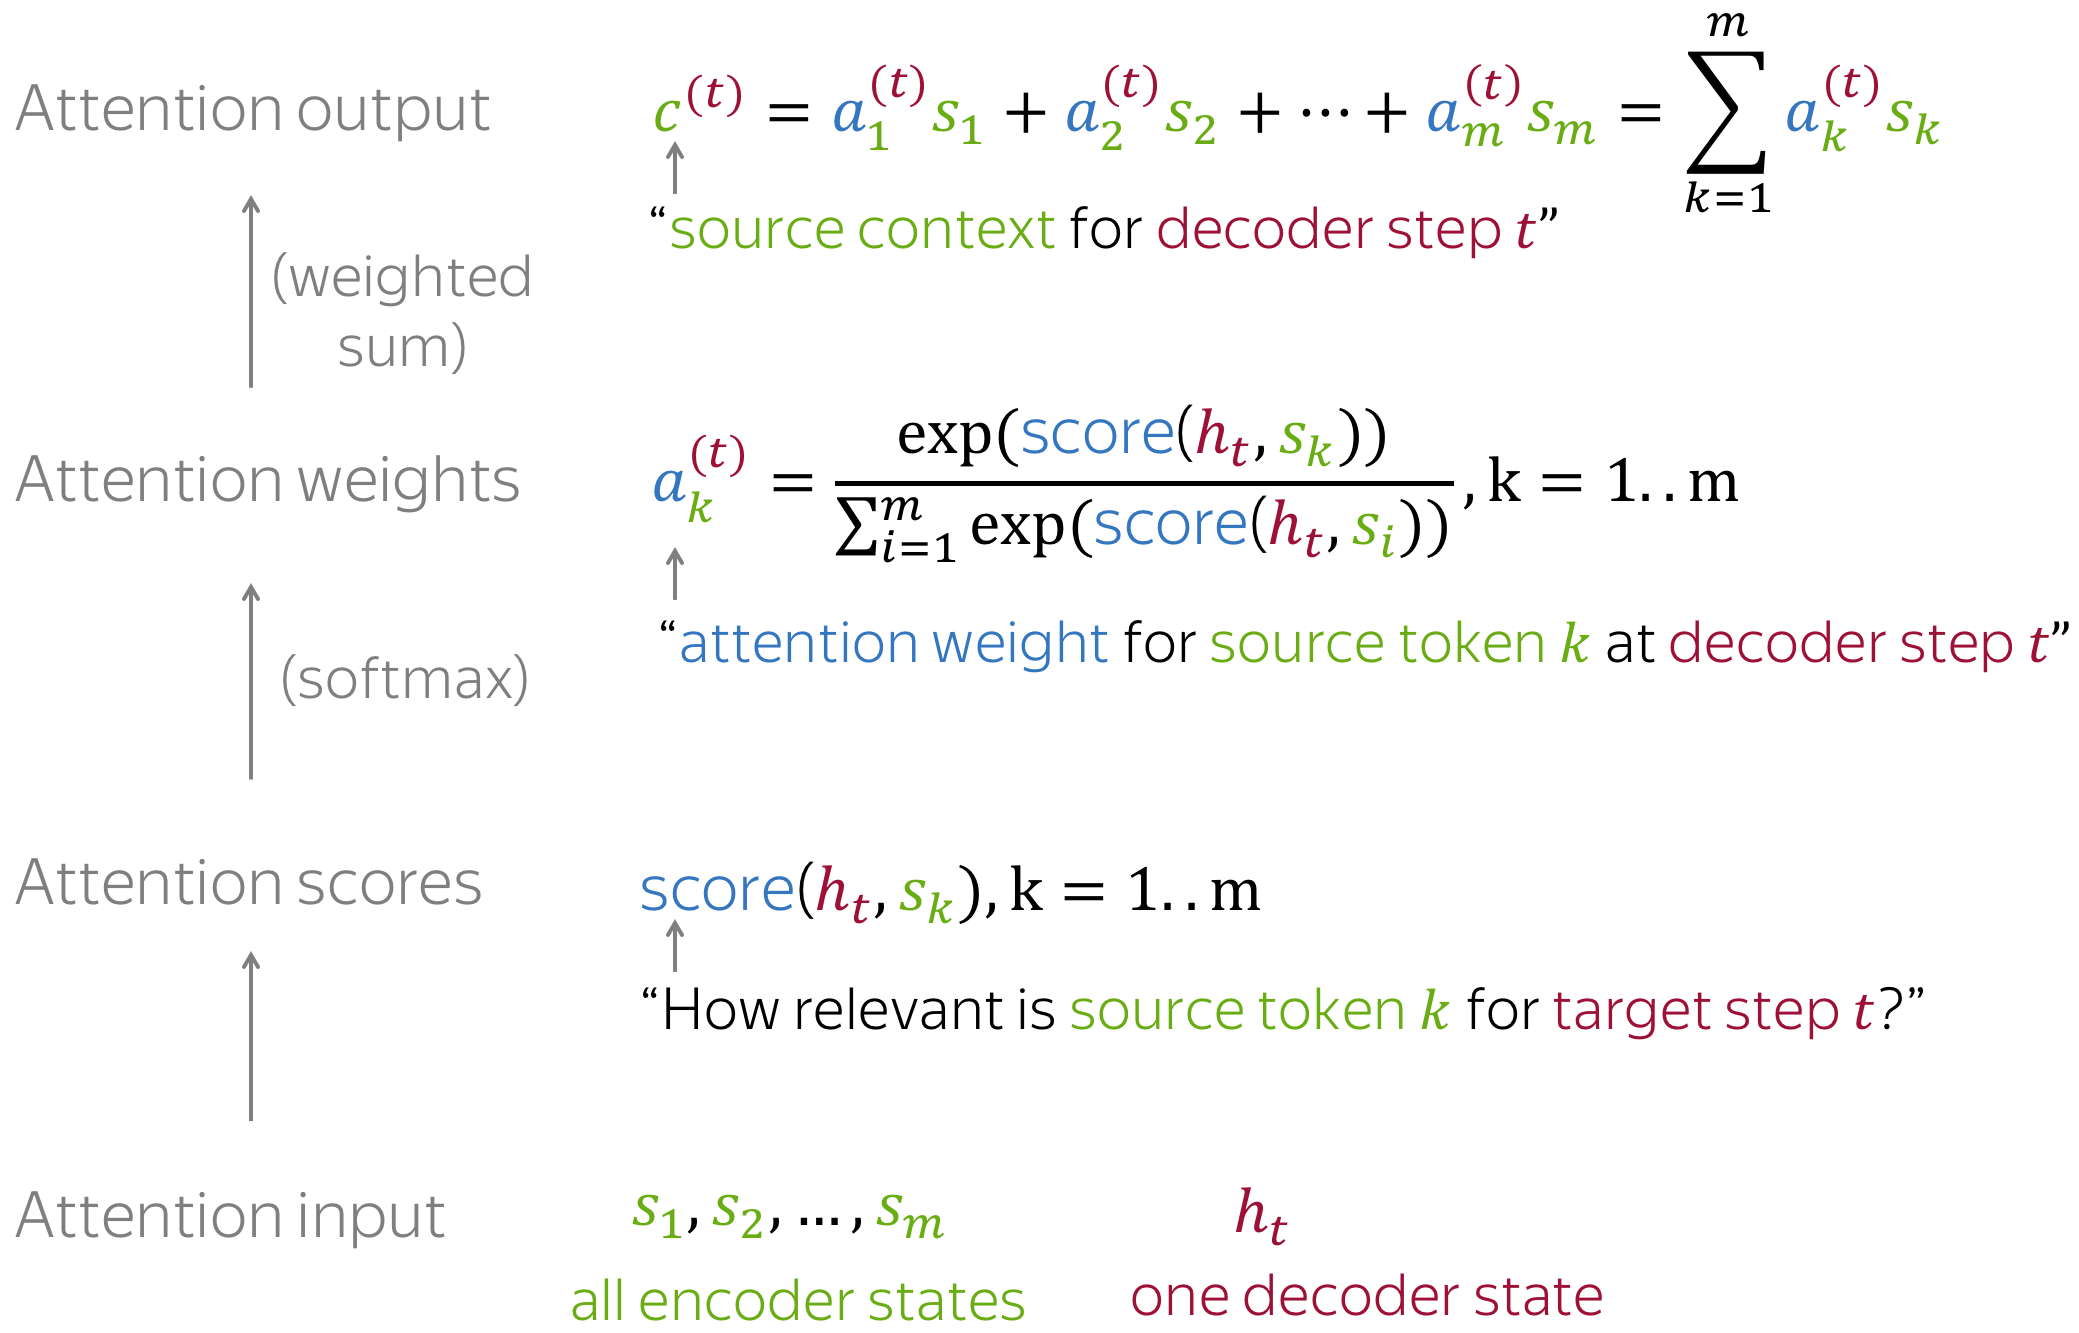

In [102]:
class Attention(nn.Module):
  def __init__(self, hid_dim):
    super(Attention, self).__init__()
    self.hid_dim = hid_dim
  
  # 是用decoder的hidden还是decoder的output？
  def forward(self, encoder_outputs, decoder_hidden):
    # encoder_outputs = [batch size, sequence len, hid dim * directions]
    # decoder_hidden = [num_layers, batch size, hid dim]
    # 一般來說是取 Encoder 最後一層的 hidden state 來做 attention
    # encoder最后一层的hidden state就是 encoder_outputs
    # softmax到底要围绕哪个dimension？


# 常見 Attention 的實作是用 Neural Network / Dot Product 來算 Decoder hidden state 和 Encoder outputs 之間的關係，
# 再對所有算出來的數值做 softmax ，最後根據過完 softmax 的值對 Encoder outputs 做 weight sum
# 你这里说attention是用decoder hidden state和encoder outputs做before softmax
# pytorch官方tutorial上是用 decoder_input, decoder_hidden做before softmax pytorch这里并没有用encoder outputs
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/a60617788061539b5449701ae76aee56/seq2seq_translation_tutorial.ipynb#scrollTo=Ulk5PKkSqr5U

    ########
    # TODO #
    ########
    batch_size, sequence_len, hid_dim_times_directions = encoder_outputs.shape
    num_layers, _, _ = decoder_hidden.shape
    dot_product = outputs.bmm(hidden.view(batch_size,hid_dim_times_directions,-1))
    weights = F.softmax(nn.Linear(dot_product.shape[2],1)(dot_product),dim=1).squeeze(2)
    squeezed_output = nn.Linear(hid_dim_times_directions,1)(outputs).squeeze(2)
    weighted_sum = torch.sum(squeezed_output*weights,dim=1)


    attention = weighted_sum
    
    return attention
    

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- 不斷地將 **Decoder** 的輸出傳回 **Decoder** ，進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [103]:
# 这种东西就很难写，因为是让你写一个class，根本看不到任何实时的反馈结果，也不知道是写对还是写错

class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
            
  def forward(self, input, target, teacher_forcing_ratio):
    # input  = [batch size, input len, vocab size]
    # target = [batch size, target len, vocab size]
    # teacher_forcing_ratio 是有多少機率使用正確答案來訓練
    batch_size = target.shape[0]
    target_len = target.shape[1]
    vocab_size = self.decoder.cn_vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, target_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      outputs[:, t] = output
      # 決定是否用正確答案來做訓練
      teacher_force = random.random() <= teacher_forcing_ratio
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      # 如果是 teacher force 則用正解訓練，反之用自己預測的單詞做預測
      input = target[:, t] if teacher_force and t < target_len else top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds

  def inference(self, input, target):
    ########
    # TODO #
    ########
    # 在這裡實施 Beam Search
    # 此函式的 batch size = 1  
    # input  = [batch size, input len, vocab size]
    # target = [batch size, target len, vocab size]
    batch_size = input.shape[0]
    input_len = input.shape[1]        # 取得最大字數
    vocab_size = self.decoder.cn_vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, input_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, input_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      # 將預測結果存起來
      outputs[:, t] = output
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      input = top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds


# utils
- 基本操作:
  - 儲存模型
  - 載入模型
  - 建構模型
  - 將一連串的數字還原回句子
  - 計算 BLEU score
  - 迭代 dataloader
  

## 儲存模型

In [104]:
def save_model(model, optimizer, store_model_path, step):
  torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
  return

## 載入模型

In [105]:
def load_model(model, load_model_path):
  print(f'Load model from {load_model_path}')
  model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
  return model

## 建構模型

In [106]:
def build_model(config, en_vocab_size, cn_vocab_size):
  # 建構模型
  encoder = Encoder(en_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
  decoder = Decoder(cn_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout, config.attention)
  model = Seq2Seq(encoder, decoder, device)
  print(model)
  # 建構 optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
  print(optimizer)
  if config.load_model:
    model = load_model(model, config.load_model_path)
  model = model.to(device)

  return model, optimizer


## 數字轉句子

In [107]:
def tokens2sentence(outputs, int2word):
  sentences = []
  for tokens in outputs:
    sentence = []
    for token in tokens:
      word = int2word[str(int(token))]
      if word == '<EOS>':
        break
      sentence.append(word)
    sentences.append(sentence)
  
  return sentences


## 計算 BLEU score

In [108]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
  score = 0 
  assert (len(sentences) == len(targets))

  def cut_token(sentence):
    tmp = []
    for token in sentence:
      if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
        tmp.append(token)
      else:
        tmp += [word for word in token]
    return tmp 

  for sentence, target in zip(sentences, targets):
    sentence = cut_token(sentence)
    target = cut_token(target)
    score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
  
  return score


##迭代 dataloader

In [109]:
def infinite_iter(data_loader):
  it = iter(data_loader)
  while True:
    try:
      ret = next(it)
      yield ret
    except StopIteration:
      it = iter(data_loader)

## schedule_sampling

In [110]:
########
# TODO #
########

# 請在這裡直接 return 0 來取消 Teacher Forcing
# 請在這裡實作 schedule_sampling 的策略

def schedule_sampling():
    return 1

# 訓練步驟

## 訓練
- 訓練階段

In [111]:
def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
  model.train()
  model.zero_grad()
  losses = []
  loss_sum = 0.0
  for step in range(summary_steps):
    sources, targets = next(train_iter)
    sources, targets = sources.to(device), targets.to(device)
    outputs, preds = model(sources, targets, schedule_sampling())
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)
    loss = loss_function(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    loss_sum += loss.item()
    if (step + 1) % 5 == 0:
      loss_sum = loss_sum / 5
      print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}      ".format(total_steps + step + 1, loss_sum, np.exp(loss_sum)), end=" ")
      losses.append(loss_sum)
      loss_sum = 0.0

  return model, optimizer, losses


## 檢驗/測試
- 防止訓練發生overfitting

In [112]:
def test(model, dataloader, loss_function):
  model.eval()
  loss_sum, bleu_score= 0.0, 0.0
  n = 0
  result = []
  for sources, targets in dataloader:
    sources, targets = sources.to(device), targets.to(device)
    batch_size = sources.size(0)
    outputs, preds = model.inference(sources, targets)
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)

    loss = loss_function(outputs, targets)
    loss_sum += loss.item()

    # 將預測結果轉為文字
    targets = targets.view(sources.size(0), -1)
    preds = tokens2sentence(preds, dataloader.dataset.int2word_cn)
    sources = tokens2sentence(sources, dataloader.dataset.int2word_en)
    targets = tokens2sentence(targets, dataloader.dataset.int2word_cn)
    for source, pred, target in zip(sources, preds, targets):
      result.append((source, pred, target))
    # 計算 Bleu Score
    bleu_score += computebleu(preds, targets)

    n += batch_size

  return loss_sum / len(dataloader), bleu_score / n, result


## 訓練流程
- 先訓練，再檢驗

In [113]:
def train_process(config):
  # 準備訓練資料
  train_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'training')
  train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
  train_iter = infinite_iter(train_loader)
  # 準備檢驗資料
  val_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'validation')
  val_loader = data.DataLoader(val_dataset, batch_size=1)
  # 建構模型
  model, optimizer = build_model(config, train_dataset.en_vocab_size, train_dataset.cn_vocab_size)
  loss_function = nn.CrossEntropyLoss(ignore_index=0)

  train_losses, val_losses, bleu_scores = [], [], []
  total_steps = 0
  while (total_steps < config.num_steps):
    # 訓練模型
    model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset)
    train_losses += loss
    # 檢驗模型
    val_loss, bleu_score, result = test(model, val_loader, loss_function)
    val_losses.append(val_loss)
    bleu_scores.append(bleu_score)

    total_steps += config.summary_steps
    print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}       ".format(total_steps, val_loss, np.exp(val_loss), bleu_score))
    
    # 儲存模型和結果
    if total_steps % config.store_steps == 0 or total_steps >= config.num_steps:
      save_model(model, optimizer, config.store_model_path, total_steps)
      with open(f'{config.store_model_path}/output_{total_steps}.txt', 'w') as f:
        for line in result:
          print (line, file=f)
    
  return train_losses, val_losses, bleu_scores


## 測試流程

In [114]:
def test_process(config):
  # 準備測試資料
  test_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'testing')
  test_loader = data.DataLoader(test_dataset, batch_size=1)
  # 建構模型
  model, optimizer = build_model(config, test_dataset.en_vocab_size, test_dataset.cn_vocab_size)
  print ("Finish build model")
  loss_function = nn.CrossEntropyLoss(ignore_index=0)
  model.eval()
  # 測試模型
  test_loss, bleu_score, result = test(model, test_loader, loss_function)
  # 儲存結果
  with open(f'./test_output.txt', 'w') as f:
    for line in result:
      print (line, file=f)

  return test_loss, bleu_score


# Config
- 實驗的參數設定表

In [115]:
class configurations(object):
  def __init__(self):
    self.batch_size = 60
    self.emb_dim = 256
    self.hid_dim = 512
    self.n_layers = 3
    self.dropout = 0.5
    self.learning_rate = 0.00005
    self.max_output_len = 50              # 最後輸出句子的最大長度
    self.num_steps = 12000                # 總訓練次數
    self.store_steps = 300                # 訓練多少次後須儲存模型
    self.summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
    self.load_model = False               # 是否需載入模型
    self.store_model_path = "./ckpt"      # 儲存模型的位置
    self.load_model_path = None           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
    self.data_path = "./cmn-eng"          # 資料存放的位置
    self.attention = False                # 是否使用 Attention Mechanism


#Main Function
- 讀入參數
- 進行訓練或是推論

## train

In [116]:
if __name__ == '__main__':
  config = configurations()
  print ('config:\n', vars(config))
  train_losses, val_losses, bleu_scores = train_process(config)


config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 300, 'summary_steps': 300, 'load_model': False, 'store_model_path': './ckpt', 'load_model_path': None, 'data_path': './cmn-eng', 'attention': False}
training dataset size: 18000
validation dataset size: 500
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention()
    (rnn): GRU(256, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2vocab2): Linear(in_features=2048, out_features=4096, bias=True)
    (embedding2vocab3): Linear(in_features=4096, out_features=3805, bias=True)
    (dropout): D

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 val [300] loss: 6.101, Perplexity: 446.290, blue score: 0.204       
 val [600] loss: 5.765, Perplexity: 319.027, blue score: 0.266       
 val [900] loss: 5.625, Perplexity: 277.181, blue score: 0.285       
 val [1200] loss: 5.587, Perplexity: 266.929, blue score: 0.300       
 val [1500] loss: 5.521, Perplexity: 249.908, blue score: 0.315       
 val [1800] loss: 5.575, Perplexity: 263.792, blue score: 0.319       
 val [2100] loss: 5.420, Perplexity: 225.781, blue score: 0.346       
 val [2400] loss: 5.296, Perplexity: 199.594, blue score: 0.351       
 val [2700] loss: 5.381, Perplexity: 217.264, blue score: 0.365       
 val [3000] loss: 5.392, Perplexity: 219.673, blue score: 0.356       
 val [3300] loss: 5.458, Perplexity: 234.711, blue score: 0.376       
 val [3600] loss: 5.340, Perplexity: 208.521, blue score: 0.378       
 val [3900] loss: 5.227, Perplexity: 186.244, blue score: 0.386       
 val [4200] loss: 5.343, Perplexity: 209.220, blue score: 0.390       
 val [450

## test

In [121]:
# 在執行 Test 之前，請先行至 config 設定所要載入的模型位置
if __name__ == '__main__':
  config = configurations()
  print ('config:\n', vars(config))
  test_loss, bleu_score = test_process(config)
  print (f'test loss: {test_loss}, bleu_score: {bleu_score}')

config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 300, 'summary_steps': 300, 'load_model': False, 'store_model_path': './ckpt', 'load_model_path': None, 'data_path': './cmn-eng', 'attention': False}
testing dataset size: 2636
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention()
    (rnn): GRU(256, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2vocab2): Linear(in_features=2048, out_features=4096, bias=True)
    (embedding2vocab3): Linear(in_features=4096, out_features=3805, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


test loss: 8.246425354788263, bleu_score: 0.010818839057896011


# 圖形化訓練過程

## 以圖表呈現 訓練 的 loss 變化趨勢

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


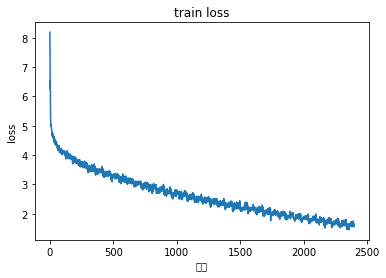

In [118]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## 以圖表呈現 檢驗 的 loss 變化趨勢

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


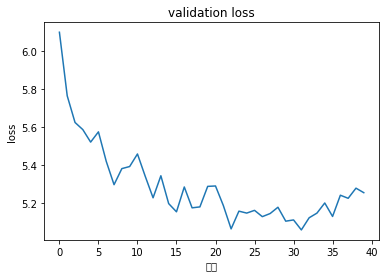

In [119]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

## BLEU score

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


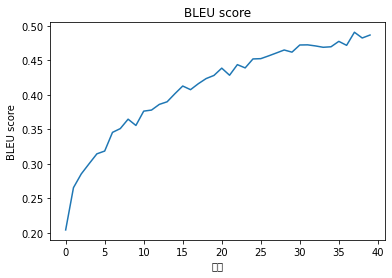

In [123]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bleu_scores)
plt.xlabel('次數')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()

In [126]:
ss = torch.load("./ckpt/model_11400.ckpt")

In [132]:
ss(en)

TypeError: ignored